# STAT40800 Data Programming with Python Final Project
## Student Name (Number): Denis O'Riordan (21201588) 
## Title: Analysing Irelands commuting patterns and its commuters from the persepctive of occupation and general health status

\newpage

### Introduction 

According to the Central Statistics Office, the census is a detailed account of everybody who is in the country at a specified time. It's primary purpose is to quantify and analyse changes in a country's population demographics. A census form is filled, fully and accurately, by each household for everyone who is in that household on a pre-specified night, known as Census Night. The forms are then returned to the Central Statistics Office who will format, aggregate and publish the data both in raw aggregated form and in analysed form such as statistics representing certain changes in demographics e.g. growth or reduction in national population. Individual census data is kept anonymous for 100 years when it is made publicly available. The census is used by the government and state bodies to plan for the future. Population and demographic changes determine how they will provide public services for the population of the State. For example, an aging population i.e. higher proportion approaching retirement age will require investment in health and care systems while a population that has had an increased birth rate will require investment in education i.e. more school places.

For this project, I have been given data from the 2016 Irish National Census which took place on Sunday, 24 April 2016. Included in this data are three datasets, corresponding with aggregated census information for counties, electoral areas and small areas. Counties in this sense are defined as administrative areas in the Republic of Ireland e.g. Cork County and Cork City are two separate entities in this regard giving a total of 31 counties. For the remainder of this report, unless stated otherwise, the term 'county' or 'counties' will refer to these administrative areas. Electoral Areas are the local electoral areas in the Republic of Ireland, a total of 137 distinct areas. Small areas are the lowest level of geography for the aggregation of statistics in line with data protection and generally comprise of either complete or partial neighbourhoods. There are 18'641 small areas in the data. The census data given covers a wide array of themes but for this analysis I am going to be focusing on the theme of commuting and it's interaction with the themes of occupation and health.

Commuting is an interesting and important theme to study for a number of reasons. Ireland has recently enacted legislation to put a legally binding target of [reducing greenhouse emissions to 51% below 2018 levels by 2030](https://www.rte.ie/news/ireland/2021/1102/1257297-cop26-ireland/) and to reach climate neutrality by 2050. According to the Sustainable Energy Authority Of Ireland (SEAI), transport was responsible for the largest share of [energy-related CO2 emissions](https://www.seai.ie/data-and-insights/seai-statistics/key-statistics/co2/) in 2018 at 39%. Reducing the contribution  of commuting related transport towards greenhouse emissions and shifting the means of commuting from private transport to public transport and active tranport (walking, cycling) will play a key role in achieving these targets. In this year alone, the National Transport Authority (NTA) has [allocated over €70m](https://www.nationaltransport.ie/planning-and-investment/transport-investment/active-travel-investment-programme/) in new funding to rural councils for active cycling and walking infrastructure and is due to publish an update to its [Greater Dublin Area Cycle Plan](https://www.nationaltransport.ie/planning-and-investment/transport-investment/greater-dublin-area-cycle-network-plan/) later in 2021. Using census data to identify regional and national trends in commuting patterns can be used to maximize the potential for increased active and public travel and therefore the best areas for further investment.

For this project I will seek to do two things. Firstly, I will use the county data sets to analyse and compare commuting trends in Ireland. Comparing commuting modes, commuting times etc. across counties. Secondly, I want to use the electoral areas data to  model the main variables of interest, active commuting and public transport commuting and use machine learning methods to discover hidden patterns in commuting patterns at a electoral area level.    

\newpage

### Data cleaning/pre-processing

#### Step 1. Reading in data.

Packages required for data cleaning and pre-processing are loaded. Subsequent required packages will be loaded as and where required.

The two relevant data files Census_by_county and Census_by_electoral_area are read in as Pandas dataframes.  
**NOTE** The data would not load initially due to *“ 'utf-8' codec can't decode byte 0xa0 in position 26: invalid start byte”* error. This required me to manually encode the data using ISO-8859-1 standard.  
Some columns in the data are read as objects and not numerics so I have read all the data in as objects and will convert all back to numerical at a later stage.  

The first sheet of the glossary file is also loaded in, its descriptions will be used for intuitive column names.

In [1]:
# import packages
# data formatting and manipulation packages
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

In [2]:
# set local path to files
path = 'C:/Users/denis/Documents/STAT40800 Data Prog with Python/Final Project/Data/'

#read file as pandas dataframes
CB_county = pd.read_csv(path+'Census_by_county.csv', index_col=False,encoding = "ISO-8859-1" , dtype = 'object')
CB_elec_area = pd.read_csv(path+'Census_by_electoral_area.csv',index_col=False,encoding = 'ISO-8859-1', dtype = 'object')
glossary = pd.read_excel(path+'Glossary.xlsx', sheet_name=0)

\newpage

#### Step 2. Picking themes    

The themes I am going to analyse alongside Commuting (Theme 11) are Disability, Carers and General Health (12) and Occupations (13).

The datasets all have identical columns. It is easy to subset by themes/tables as they follow identical patterns. All columns begin with 'T' followed by theme number followed by '_' followed by table number. Columns ending in T consist of total population, M for male population and F for female population. As the theme of Commuting does not have figures for genders I am going to drop all male/female columns to create a concise dataset. Commuting is instead split by work, school/college and total, fields ending in 'W', 'S', and 'T' respectively. I am going to examine commuting trends for the working population and the population in education separately so the total fields\ (ending in 'T') are dropped for the theme of commuting.  

I will be dropping the following tables from certain themes as they are not in scope of this analysis.    
- Disibility and carer numbers from theme 12 i.e. only table 3 is used  

The geographic columns *GUID* and *GEOGID* are also dropped from the datasets as they provide no relevant information. *GEOGDESC* is retained. 


In [3]:
# create lists of the columns to kept from the appropriate tables from the selected themes
GEO_cols = [col for col in CB_county if col.startswith('G')] 
T11_cols = [col for col in CB_county if (col.startswith('T11_') and not col.endswith('T'))]
T12_cols = [col for col in CB_county if (col.startswith('T12_3') and col.endswith('T'))]
T13_cols = [col for col in CB_county if (col.startswith('T13_') and col.endswith('T'))]

#subset the data using the column lists defined above to retain only the relevant columns
CB_elec_area = CB_elec_area[GEO_cols + T11_cols + T12_cols + T13_cols]
CB_county = CB_county[GEO_cols+  T11_cols + T12_cols + T13_cols]

# drop 'GUID'and 'GEOGID' columns
CB_county= CB_county.drop(['GUID', 'GEOGID'], axis=1)
CB_elec_area = CB_elec_area.drop(['GUID', 'GEOGID'], axis=1)

\newpage

#### Step 3 Glossary manipulation - naming columns   

The column names and descriptions are extracted from the glossary dataframe using a similar method as was used for the census files. 

In [4]:
# subset glossary, keeping only the two relevant columns, column name and decription of field 
glossary = glossary[['Column Names', 'Description of Field']]

In [5]:
#create and append subsets of glossary that correspond to the fields of the themes 

#theme 11
T11_1desc = glossary[glossary['Column Names'].str.startswith('T11_1', na=False)]
T11S_desc = T11_1desc[(T11_1desc['Column Names'].str.endswith('S', na=False))]
T11W_desc = T11_1desc[(T11_1desc['Column Names'].str.endswith('W', na=False))]
T11_1desc = pd.concat([T11W_desc,T11S_desc])
T11_2desc = glossary[glossary['Column Names'].str.startswith('T11_2', na=False)]
T11_3desc = glossary[glossary['Column Names'].str.startswith('T11_3', na=False)]
T11_desc = pd.concat([T11_1desc,T11_2desc,T11_3desc])
T11_desc = T11_desc.drop(T11_desc[(T11_desc['Column Names'] == 'T11_2_T') | (T11_desc['Column Names'] == 'T11_3_T')].index)

# theme 12
T12_desc = glossary[glossary['Column Names'].str.startswith('T12_3', na=False)]
T12_desc = T12_desc[T12_desc['Column Names'].str.endswith('T', na=False)]

# theme 13
T13_desc = glossary[glossary['Column Names'].str.startswith('T13_', na=False)]
T13_desc = T13_desc[T13_desc['Column Names'].str.endswith('T', na=False)]


#join rows together to form DESC
#DESC is a dataframe containing the column names of the datset and its description from the glossary
DESC = T11_desc.append([T12_desc,T13_desc], ignore_index=True)

\newpage

There are a number of duplicated column descriptions e.g. 'Total' in this list so these have their column name appended in order to distinguish them.

In [6]:
#create DUPE_DESC, list of duplicated rows of DESC
DUPE_DESC = DESC[DESC.duplicated(subset=['Description of Field'])].reset_index()
DUPE_DESC

,index,Column Names,Description of Field
0,39,T11_3_NS,Not stated
1,56,T13_1_NST,Not stated - Total
2,57,T13_1_TT,Total


In [7]:
#alter duplicates file and concatenate the field name to the description
for i in range(0,len(DUPE_DESC)):
    DESC['Description of Field'][DESC['Column Names'] == DUPE_DESC.iloc[i, 1]] = DUPE_DESC.iloc[i, 1] + ' ' + DESC['Description of Field'][DESC['Column Names'] == DUPE_DESC.iloc[i, 1]]
#recheck for duplicates
DUPE_DESC2 = DESC[DESC.duplicated(subset=['Description of Field'])].reset_index()
DUPE_DESC2.shape[0]

0

\newpage

Finally the column name in each census dataset are changed to the corresponding description field. *GEOGDESC* is also changed to *'Area'*.

In [8]:
DESC.head()

,Column Names,Description of Field
0,T11_1_FW,On foot - Work
1,T11_1_BIW,Bicycle - Work
2,T11_1_BUW,"Bus, minibus or coach - Work"
3,T11_1_TDLW,"Train, DART or LUAS - Work"
4,T11_1_MW,Motorcycle or scooter - Work


In [9]:
# Use DESC to rename the column names from the census datasets 
# the rows of the column names and description in DESC follow the same order as the columns in the census data
# NOTE the census data contains the GEOGDESC column at the beginning 
# so it needs to begin at column 1 of census data for row 0 of DESC 

for i in range(1, len(CB_county.columns)):
    CB_county = CB_county.rename(columns={CB_county.columns[i]: DESC['Description of Field'].iloc[i-1]})
    CB_elec_area = CB_elec_area.rename(columns={CB_elec_area.columns[i]: DESC['Description of Field'].iloc[i-1]})   

# manually rename GEOGDESC as Area for the data as its more intuitive    
CB_county = CB_county.rename(columns={'GEOGDESC': 'Area'})
CB_elec_area = CB_elec_area.rename(columns={'GEOGDESC': 'Area'})

\newpage

#### Step 4 Column Manipluation  


In [10]:
#dimensions of county census dataframe
CB_county.shape

(31, 59)

The datasets now contain 59 columns. Columns that do not add value to analysis of this scope are dropped from the datasets. Other columns will be merged to create new columns where appropriate.    

Before that however, I will reconvert the datasets back to numeric values using pd.to_numeric() and str.replace() to drop any commas.

In [11]:
#create list of column names of datset - column names are identical between all three census datasets
col_list = CB_county.columns.tolist()

# remove comma and convert every column to numeric to allow for manipulation and analysis
for i in range(1,len(col_list)):
    CB_county[col_list[i]] = pd.to_numeric(CB_county[col_list[i]].str.replace(',', ''))
    CB_elec_area[col_list[i]] = pd.to_numeric(CB_elec_area[col_list[i]].str.replace(',', ''))

\newpage

#### Step 5 Merge and create new columns of interest    

Before any further manipulation, I will check if any of the datasets contain null/missing values at this point

In [12]:
# isnull() to count number of missing values 
# sum() called twice to sum over rows and columns
print(CB_county.isnull().sum().sum() + CB_elec_area.isnull().sum().sum())

0


In the occupations theme there are nine distinctive types of occupation. Broader employment categories are created based of the types of occupation while still capturing the essence of the occupation.  
- *professional_employment* - managerial, professionsal, adminstrative roles etc.  
- *service_employment* - sales, customer service, leisure, caring roles etc.  
- *trade_employment* - skilled trades e.g. electrician  
- *low_skilled_employment* - low skilled employment  

A new column is added for each of these categories containg the sum of its constituent columns and then the constituent columns are dropped.

In [13]:
#define broader employment categories based of fields in theme of occupation
professional_employment = ['Managers, directors and senior officials - Total',
       'Professional occupations - Total', 'Associate professional and technical occupations - Total',
       'Administrative and secretarial occupations - Total']
service_employment = ['Caring, leisure and other service occupations - Total',
       'Sales and customer service occupations - Total']
trade_employment = ['Skilled trades occupations - Total']
low_skilled_employment = ['Process, plant and machine operatives - Total','Elementary occupations - Total']

# add new commuting summary columns to county census data
# new columns are sums of columns listed above
CB_county['professional_employment'] = CB_county[professional_employment].sum(axis=1)
CB_county['service_employment'] = CB_county[service_employment].sum(axis=1)
CB_county['trade_employment'] = CB_county[trade_employment].sum(axis=1)
CB_county['low_skilled_employment'] = CB_county[low_skilled_employment].sum(axis=1)

# add new commuting summary columns to small area census data
# new columns are sums of columns listed above
CB_elec_area['professional_employment'] = CB_elec_area[professional_employment].sum(axis=1)
CB_elec_area['service_employment'] = CB_elec_area[service_employment].sum(axis=1)
CB_elec_area['trade_employment'] = CB_elec_area[trade_employment].sum(axis=1)
CB_elec_area['low_skilled_employment'] = CB_elec_area[low_skilled_employment].sum(axis=1)

# drop constituent columns from data
CB_elec_area = CB_elec_area.drop((professional_employment + service_employment + trade_employment 
                            + low_skilled_employment), axis=1)
CB_county = CB_county.drop((professional_employment + service_employment + trade_employment 
                            + low_skilled_employment), axis=1)

\newpage

In a similar way to above,modes of transport are merged into three main forms - active, public and private.    
- Active transport consists of walking or cycling.  
- Public transport consists of taking a bus, minibus coach, train, DART or Luas  
- Private tranport consists of all other forms of private vehicle including being a passenger in a private vehicle.   

A new columns added to the datasets using the sums of the appropriate columns as described above and the constituent columns are then dropped from the datasets.

In [14]:
# define the commuting sets for working population
Active_Transport_Work = ['On foot - Work', 'Bicycle - Work']
Public_Transport_Work = ['Bus, minibus or coach - Work', 'Train, DART or LUAS - Work']
Private_Transport_Work = ['Motorcycle or scooter - Work', 'Car driver - Work','Car passenger - Work', 
                          'Van - Work', 'Other (incl. lorry) - Work']

# define the commuting sets for population in education
Active_Transport_edu = ['On foot - School or college','Bicycle - School or college']
Public_Transport_edu = ['Bus, minibus or coach - School or college', 'Train, DART or LUAS - School or college']
Private_Transport_edu = ['Motorcycle or scooter - School or college', 'Car driver - School or college',
                          'Car passenger - School or college', 
                          'Van - School or college', 'Other (incl. lorry) - School or college']

# add new commuting summary columns to county census data
# new columns are sums of columns listed above
CB_county['Active_Transport_Work'] = CB_county[Active_Transport_Work].sum(axis=1)
CB_county['Public_Transport_Work'] = CB_county[Public_Transport_Work].sum(axis=1)
CB_county['Private_Transport_Work'] = CB_county[Private_Transport_Work].sum(axis=1)
CB_county['Active_Transport_edu'] = CB_county[Active_Transport_edu].sum(axis=1)
CB_county['Public_Transport_edu'] = CB_county[Public_Transport_edu].sum(axis=1)
CB_county['Private_Transport_edu'] = CB_county[Private_Transport_edu].sum(axis=1)

#add new commuting summary columns to small area census data
CB_elec_area['Active_Transport_Work'] = CB_elec_area[Active_Transport_Work].sum(axis=1)
CB_elec_area['Public_Transport_Work'] = CB_elec_area[Public_Transport_Work].sum(axis=1)
CB_elec_area['Private_Transport_Work'] = CB_elec_area[Private_Transport_Work].sum(axis=1)
CB_elec_area['Active_Transport_edu'] = CB_elec_area[Active_Transport_edu].sum(axis=1)
CB_elec_area['Public_Transport_edu'] = CB_elec_area[Public_Transport_edu].sum(axis=1)
CB_elec_area['Private_Transport_edu'] = CB_elec_area[Private_Transport_edu].sum(axis=1)

# drop constituent columns from data
CB_elec_area = CB_elec_area.drop((Active_Transport_Work + Public_Transport_Work + Private_Transport_Work 
                            + Active_Transport_edu + Public_Transport_edu +  Private_Transport_edu), axis=1)
CB_county = CB_county.drop((Active_Transport_Work + Public_Transport_Work + Private_Transport_Work 
                            + Active_Transport_edu + Public_Transport_edu +  Private_Transport_edu), axis=1)


\newpage

The leaving time and commuting length tables are aggregated into three variables each.  
- early leaving time: before 07:30
- middle leaving times: between 07:30 and 8:30
- late leaving times: after 08:30    
  
  
- short commute length: less than 30 mins
- mid-size commute length: between 30 mins and an hour
- long commute length: over an hour

In [15]:
# define fields corresponding to each leaving time/communte length
early_leaving = ['Before 06:30', '06:30 - 07:00', '07:01 - 07:30']
mid_leaving = ['07:31 - 08:00', '08:01 - 08:30']
late_leaving = ['08:31 - 09:00', '09:01 - 09:30', 'After 09:30']
short_commute = ['Under 15 mins', '1/4 hour - under 1/2 hour']
mid_commute = ['1/2 hour - under 3/4 hour','3/4 hour - under 1 hour' ]
long_commute = ['1 hour - under 1 1/2 hours','1 1/2 hours and over']

#create new columns in County dataset using sum of sets defined above
CB_county['early_leaving'] = CB_county[early_leaving].sum(axis=1)
CB_county['mid_leaving'] = CB_county[mid_leaving].sum(axis=1)
CB_county['late_leaving'] = CB_county[late_leaving].sum(axis=1)
CB_county['short_commute'] = CB_county[short_commute].sum(axis=1)
CB_county['mid_commute'] = CB_county[mid_commute].sum(axis=1)
CB_county['long_commute'] = CB_county[long_commute].sum(axis=1)

#create new columns in small area dataset using sum of sets defined above
CB_elec_area['early_leaving'] = CB_elec_area[early_leaving].sum(axis=1)
CB_elec_area['mid_leaving'] = CB_elec_area[mid_leaving].sum(axis=1)
CB_elec_area['late_leaving'] = CB_elec_area[late_leaving].sum(axis=1)
CB_elec_area['short_commute'] = CB_elec_area[short_commute].sum(axis=1)
CB_elec_area['mid_commute'] = CB_elec_area[mid_commute].sum(axis=1)
CB_elec_area['long_commute'] = CB_elec_area[long_commute].sum(axis=1)

#drop constituent columns from dataset
CB_elec_area = CB_elec_area.drop((early_leaving + mid_leaving + late_leaving
                            + short_commute +mid_commute +long_commute), axis=1)
CB_county = CB_county.drop((early_leaving + mid_leaving + late_leaving
                            + short_commute +mid_commute +long_commute), axis=1)

\newpage

Columns realting to general health are also broadened.
- Good_Health: good health and very good health
- Bad_Health: bad health and very bad health
- Fair health is unchanged

In [16]:
# define fields corresponding to each leaving time/communte length
Good_Health = ['Very good - Total', 'Good - Total']
Bad_Health = ['Bad - Total', 'Very bad - Total']

CB_county['Good Health'] = CB_county[Good_Health].sum(axis=1)
CB_county['Bad Health'] = CB_county[Bad_Health].sum(axis=1)

#create new columns in small area dataset using sum of sets defined above
CB_elec_area['Good Health'] = CB_elec_area[Good_Health].sum(axis=1)
CB_elec_area['Bad Health'] = CB_elec_area[Bad_Health].sum(axis=1)

#drop constituent columns from dataset
CB_elec_area = CB_elec_area.drop((Good_Health + Bad_Health), axis=1)
CB_county = CB_county.drop((Good_Health + Bad_Health), axis=1)

#### Step 6 Other manual adjustments

Fields that are of the form 'Not stated' are removed as they provide very little information on every variable/table they are part of.  

Workers and people who in education who mainly work/learn from home (WFH) are also dropped from the dataset. While WFH trends are relevant to the overall analysis of commuting in Ireland, particularly in a post-Covid-19 Ireland, they are not within the scope of this analysis as I want to look at those who travel to their work or education.

It is worth noting for future reference that because these cohorts of respondants have been removed from the datasets, the sum of remaining commuters in the data will not add up to the given total figures.

In [17]:
# fields that are of the form 'not stated'
Not_stated = ['Not stated - Work', 'Not stated - School or college', 'Not stated', 
              'T11_3_NS Not stated', 'Not stated - Total','T13_1_NST Not stated - Total']
# drop fields defined above
CB_county = CB_county.drop(Not_stated, axis=1)
CB_elec_area = CB_elec_area.drop(Not_stated, axis=1)

No_commute =['Work mainly at or from home - Work', 
             'Work mainly at or from home - School or college']
# drop fields defined above
CB_county = CB_county.drop(No_commute, axis=1)
CB_elec_area = CB_elec_area.drop(No_commute, axis=1)

A further manual update is made to some column names in order to remove any ambiguity.

In [18]:
#rename certain columns to give a better more concise description
CB_county = CB_county.rename(columns={'T13_1_TT Total': 'Total - Occupation', 'Total - School or college':'education',
                                      'Total': 'Total_Health', 'Fair - Total': 'Fair Health',})
CB_elec_area = CB_elec_area.rename(columns={'T13_1_TT Total': 'Total - Occupation', 'Total - School or college':'education',
                                      'Total': 'Total_Health', 'Fair - Total': 'Fair Health',})

\newpage

#### Step 7 Convert to proportions

Areas with higher populations will likely have a larger number of all variables so it is best to convert the variables of interest into proportions of the appropriate totals for my analysis.  

In [19]:
#County Data
# covert variables to proprortions of the appropirate totals
# commuting to work
CB_county['active_work'] = CB_county['Active_Transport_Work']/CB_county['Total - Work']
CB_county['public_work'] = CB_county['Public_Transport_Work']/CB_county['Total - Work']
CB_county['private_work'] = CB_county['Private_Transport_Work']/CB_county['Total - Work']

#commuting to education
CB_county['active_edu'] = CB_county['Active_Transport_edu']/CB_county['education']
CB_county['public_edu'] = CB_county['Public_Transport_edu']/CB_county['education']
CB_county['private_edu'] = CB_county['Private_Transport_edu']/CB_county['education']

# commute leaving time
CB_county['early_leave'] = CB_county['early_leaving']/(CB_county['education'] + CB_county['Total - Work'])
CB_county['mid_leave'] = CB_county['mid_leaving']/(CB_county['education'] + CB_county['Total - Work'])
CB_county['late_leave'] = CB_county['late_leaving']/(CB_county['education'] + CB_county['Total - Work'])

# commute length
CB_county['short_length'] = CB_county['short_commute']/(CB_county['education'] + CB_county['Total - Work'])
CB_county['mid_length'] = CB_county['mid_commute']/(CB_county['education'] + CB_county['Total - Work'])
CB_county['long_length'] = CB_county['long_commute']/(CB_county['education'] + CB_county['Total - Work'])

# general health status
CB_county['good_health'] = CB_county['Good Health']/CB_county['Total_Health']
CB_county['bad_health'] = CB_county['Bad Health']/CB_county['Total_Health']
CB_county['fair_health'] = CB_county['Fair Health']/CB_county['Total_Health']

#occupation
CB_county['professional'] = CB_county['professional_employment']/CB_county['Total - Occupation']
CB_county['service'] = CB_county['service_employment']/CB_county['Total - Occupation']
CB_county['trade'] = CB_county['trade_employment']/CB_county['Total - Occupation']
CB_county['low_skilled'] = CB_county['low_skilled_employment']/CB_county['Total - Occupation']

# drop raw figure columns
CB_county = CB_county.drop(['Active_Transport_Work', 'Public_Transport_Work', 'Private_Transport_Work',
                           'Active_Transport_edu', 'Public_Transport_edu', 'Private_Transport_edu',
                           'early_leaving', 'mid_leaving', 'late_leaving',
                           'short_commute', 'mid_commute', 'long_commute',
                           'Good Health', 'Bad Health', 'Fair Health',
                           'professional_employment', 'service_employment',
                           'trade_employment', 'low_skilled_employment'], axis=1)

In [20]:
#County Data
# covert variables to proprortions of the appropirate totals
# commuting mode to work
CB_elec_area['active_work'] = CB_elec_area['Active_Transport_Work']/CB_elec_area['Total - Work']
CB_elec_area['public_work'] = CB_elec_area['Public_Transport_Work']/CB_elec_area['Total - Work']
CB_elec_area['private_work'] = CB_elec_area['Private_Transport_Work']/CB_elec_area['Total - Work']

#commuting mode to education
CB_elec_area['active_edu'] = CB_elec_area['Active_Transport_edu']/CB_elec_area['education']
CB_elec_area['public_edu'] = CB_elec_area['Public_Transport_edu']/CB_elec_area['education']
CB_elec_area['private_edu'] = CB_elec_area['Private_Transport_edu']/CB_elec_area['education']

# commute leaving time
CB_elec_area['early_leave'] = CB_elec_area['early_leaving']/(CB_elec_area['education'] + CB_elec_area['Total - Work'])
CB_elec_area['mid_leave'] = CB_elec_area['mid_leaving']/(CB_elec_area['education'] + CB_elec_area['Total - Work'])
CB_elec_area['late_leave'] = CB_elec_area['late_leaving']/(CB_elec_area['education'] + CB_elec_area['Total - Work'])

# commute length
CB_elec_area['short_length'] = CB_elec_area['short_commute']/(CB_elec_area['education'] + CB_elec_area['Total - Work'])
CB_elec_area['mid_length'] = CB_elec_area['mid_commute']/(CB_elec_area['education'] + CB_elec_area['Total - Work'])
CB_elec_area['long_length'] = CB_elec_area['long_commute']/(CB_elec_area['education'] + CB_elec_area['Total - Work'])

# general health status
CB_elec_area['good_health'] = CB_elec_area['Good Health']/CB_elec_area['Total_Health']
CB_elec_area['bad_health'] = CB_elec_area['Bad Health']/CB_elec_area['Total_Health']
CB_elec_area['fair_health'] = CB_elec_area['Fair Health']/CB_elec_area['Total_Health']

#occupation
CB_elec_area['professional'] = CB_elec_area['professional_employment']/CB_elec_area['Total - Occupation']
CB_elec_area['service'] = CB_elec_area['service_employment']/CB_elec_area['Total - Occupation']
CB_elec_area['trade'] = CB_elec_area['trade_employment']/CB_elec_area['Total - Occupation']
CB_elec_area['low_skilled'] = CB_elec_area['low_skilled_employment']/CB_elec_area['Total - Occupation']

# drop raw figure columns
CB_elec_area = CB_elec_area.drop(['Active_Transport_Work', 'Public_Transport_Work', 'Private_Transport_Work',
                           'Active_Transport_edu', 'Public_Transport_edu', 'Private_Transport_edu',
                           'early_leaving', 'mid_leaving', 'late_leaving',
                           'short_commute', 'mid_commute', 'long_commute',
                           'Good Health', 'Bad Health', 'Fair Health',
                           'professional_employment', 'service_employment',
                           'trade_employment', 'low_skilled_employment'], axis=1)


\newpage

#### Final Dataset

In [21]:
CB_county.columns

Index(['Area', 'Total - Work', 'education', 'Total_Health',
       'Total - Occupation', 'active_work', 'public_work', 'private_work',
       'active_edu', 'public_edu', 'private_edu', 'early_leave', 'mid_leave',
       'late_leave', 'short_length', 'mid_length', 'long_length',
       'good_health', 'bad_health', 'fair_health', 'professional', 'service',
       'trade', 'low_skilled'],
      dtype='object')

In [22]:
print(CB_county.shape)
print(CB_elec_area.shape)

(31, 24)
(137, 24)


At the end of the data processing stage I am left with three datasets each containing 24 columns. While initially this may seem excessive, a considerable amount of them are effectively different categories of the same variable e.g. there are four variables pertaining to type of occupation.  

The main sets of variables in my finalised dataset are
- area (not relevant in small area dataset)
- population in education
- population at work and by occupation category
- means of commuting for population in education
- means of commuting for population at work 
- leaving time to travel to work or education
- journey time to work or education
- general health

\newpage

## Exploratory data analysis

### Commuting demographics for work by county

For this section, I am exploring the modes of commuting of interest active travel and public transport, for the working population as a a proportion of the total working population.  

Taking descriptive values using pd.describe() for this data would not be appropriate as the proportions are based off populations of different sizes. It would not be appropriate to calculate these descriptive statistics if each county's proportion had equal weight. Instead I will calculate the weighted mean of each proportion using commuting modes, using the total population as the weights. This is available using `np.average()` function 

I will also list the counties with the top five highest and lowest proportional use of each commuting modes.

##### Active Travel

In [23]:
# weighted average for national proportion of commuters who commute via active travel , weights as total work population 
print('The weighted average of the proportion who use active travel to commute to work is:', 
     round(np.average(CB_county['active_work'], weights=CB_county['Total - Work']),3))
print('\n')

# top 5 rows of data ordered by highest proportion of commuters who commute via active travel
print('The five counties with the highest proportion active travel commuters to work are:')
print(CB_county.sort_values(by=['active_work'], ascending=False)[['Area', 'active_work']].head())
print('\n')

# top 5 rows of data ordered by lowest proportion of commuters who commute via active travel
print('The five counties with the lowest proportion of active travel commuters to work are:')
print(CB_county.sort_values(by=['active_work'])[['Area', 'active_work']].head())

The weighted average of the proportion who use active travel to commute to work is: 0.118


The five counties with the highest proportion active travel commuters to work are:
                      Area  active_work
5              Dublin City     0.301197
0                Cork City     0.237644
9              Galway City     0.216296
7   Dún Laoghaire-Rathdown     0.133956
15                   Louth     0.121279


The five counties with the lowest proportion of active travel commuters to work are:
             Area  active_work
23      Roscommon     0.049441
10  Galway County     0.055857
19          Meath     0.059218
17        Leitrim     0.060285
2     Cork County     0.062529


##### Public Transport

In [24]:
# weighted average for national proportion of commuters who commute via public transport , weights as total work population 
print('The weighted average of public transport commuters to work is:', 
     round(np.average(CB_county['public_work'], weights=CB_county['Total - Work']),3))
print('\n')

# top 5 rows of data ordered by highest proportion of commuters who commute via public transport
print('The five counties with the highest proportion of public transport commuters to work are:')
print(CB_county.sort_values(by=['public_work'], ascending=False)[['Area', 'public_work']].head())
print('\n')

# top 5 rows of data ordered by lowest proportion of commuters who commute via public transport
print('The five counties with the lowest proportion of public transport commuters to work are:')
print(CB_county.sort_values(by=['public_work'])[['Area', 'public_work']].head())

The weighted average of public transport commuters to work is: 0.089


The five counties with the highest proportion of public transport commuters to work are:
                      Area  public_work
7   Dún Laoghaire-Rathdown     0.231734
5              Dublin City     0.221917
8                   Fingal     0.203719
24            South Dublin     0.154882
0                Cork City     0.112251


The five counties with the lowest proportion of public transport commuters to work are:
         Area  public_work
21       Mayo     0.009580
17    Leitrim     0.011308
13      Kerry     0.011593
26  Tipperary     0.012231
20   Monaghan     0.012589


Public and active transport is far more popular in urban areas i.e. cities. Dublin City, Cork City and Dún Laoghaire-Rathdown are all in the top five counties in terms of proportion of workers commuting via public and active transport.  

Leitrim is the only county in in the lowest five counties both in terms of population who commute to work via public and active transport. Just over 1% of Leitrims workers commute via public transport and 6% commute via active travel.  

To get a better understanding of the overall spread of values for each commuting mode for each county I have overlaid the histograms of all three forms on the one plot below. I will also include the histogram of the values for the proportion of the population who commute to work via private transport. While there is not scope in this project to look at private transport in the same detail as active and public tranport, there is benefit in seeing where how the values are distributed on a more general scale. 

In [25]:
# import plotting package matplotlib
import matplotlib.pyplot as plt

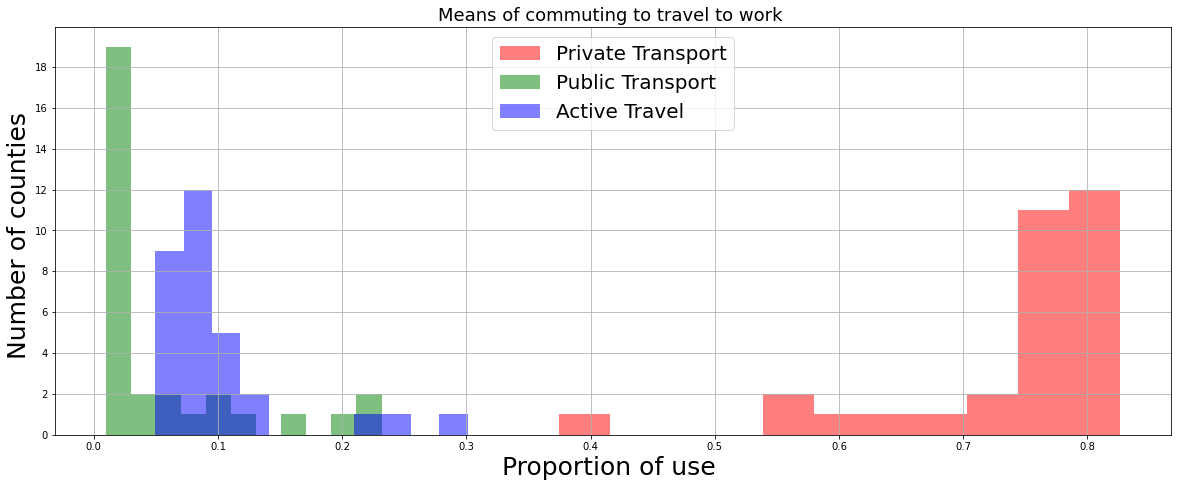

In [26]:
# set figure size
plt.figure(figsize=(20,7.5))

# plot histogram of each of three mode of commuting for workers 
# with distinct colours and appropriate labels and transparency
CB_county['private_work'].hist(bins = 11,color='red',alpha=0.5, 
                         label = "Private Transport")
CB_county['public_work'].hist(bins = 11,color='green',alpha=0.5, 
                               label = "Public Transport")
CB_county['active_work'].hist(bins = 11,color='blue',alpha=0.5, 
                               label = "Active Travel")
# titles, labels etc.
plt.title("Means of commuting to travel to work ", fontsize = 18)
plt.legend(fontsize = 20, loc=9)
plt.xlabel('Proportion of use ', fontsize = 25)
plt.ylabel('Number of counties ', fontsize = 25)
plt.yticks(np.arange(0, 20, step = 2))
plt.show()

Private transport is by far the most popular mode of commuting for workers. It also has the widest spread amongst counties, ranging from over 0.8 to 0.4 although the counties where only 0.4 of workers commute by public transport seems an outlier. In the majority counties, between 0.75 and 0.85 of all workers commute via private transport.  
For over half of the counties, less than 0.05 of workers commute to work via public transport. This is the most narrow concentration of commuters across all modes of commuting. Only in four counties do more than 0.15 of commuters commute to work via public transport.  
Less than 0.1 of workers commute to work via active transport for over half of the counties, and only in three counties do more than 0.2 of commuters commute to work via active transport.

\newpage

### Commuting demographics for education by county

Below I will be replicating my analysis above but on the population who commute to school/college.

##### Active Travel

In [27]:
# weighted average for national proportion of commuters who commute to school/college via active travel 
# weights as total population in education 
print('The weighted average of active travel commuters to education is:', 
     round(np.average(CB_county['active_edu'], weights=CB_county['education']),3),'\n')

# top 5 rows of data ordered by highest proportion of commuters who commute to education via active travel
print('The five counties with the highest proportion of active commuters to education are:')
print(CB_county.sort_values(by=['active_edu'], ascending=False)[['Area', 'active_edu']].head(),'\n')

# top 5 rows of data ordered by lowest proportion of commuters who commute to education via active travel
print('The five counties with the lowest proportion of active commuters to education are:')
print(CB_county.sort_values(by=['active_edu'])[['Area', 'active_edu']].head())

The weighted average of active travel commuters to education is: 0.254 

The five counties with the highest proportion of active commuters to education are:
            Area  active_edu
0      Cork City    0.489012
5    Dublin City    0.476474
9    Galway City    0.411062
24  South Dublin    0.370466
8         Fingal    0.361312 

The five counties with the lowest proportion of active commuters to education are:
             Area  active_edu
6         Donegal    0.109852
10  Galway County    0.114789
23      Roscommon    0.116308
3           Cavan    0.137366
21           Mayo    0.139334


##### Public Transport

In [28]:
# weighted average for national proportion of commuters who commute via public transport , 
# weights as total population in school/college 
print('The weighted average of public transport commuters to work is:', 
     round(np.average(CB_county['public_edu'], weights=CB_county['education']),3), '\n')

# top 5 rows of data ordered by highest proportion of commuters who commute to education via public transport
print('The five counties with the highest proportion of public transport commuters to education are:')
print(CB_county.sort_values(by=['public_edu'], ascending=False)[['Area', 'public_edu']].head(), '\n')

# top 5 rows of data ordered by lowest proportion of commuters who commute to education via public transport
print('The five counties with the lowest proportion of public transport commuters to education are:')
print(CB_county.sort_values(by=['public_edu'])[['Area', 'public_edu']].head())

The weighted average of public transport commuters to work is: 0.203 

The five counties with the highest proportion of public transport commuters to education are:
        Area  public_edu
6    Donegal    0.314498
3      Cavan    0.291117
17   Leitrim    0.283265
20  Monaghan    0.265747
14  Longford    0.261521 

The five counties with the lowest proportion of public transport commuters to education are:
                         Area  public_edu
0                   Cork City    0.100646
9                 Galway City    0.129582
4                      Carlow    0.138881
27  Waterford City and County    0.140579
16   Limerick City and County    0.147072


There are a number of similarities between commuting for work and commuting by education as shown by these statistics.
Again city areas have the highest proportions of active commuters to education and lowest proportion of commuters via private transport.  
However for education, there are no urban areas in the top five counties ordered by proprortion who commute via public transport. In fact, Cork City and Galway City are in the lowest five counties in terms of proportion who commute to school via public transport. This can be explained by the provision of special bus routes for schoolchildren in Ireland.  

To get a better understanding of the overall spread of values for each commuting mode for each county I have overlaid the histograms of all three forms on the one plot below.  

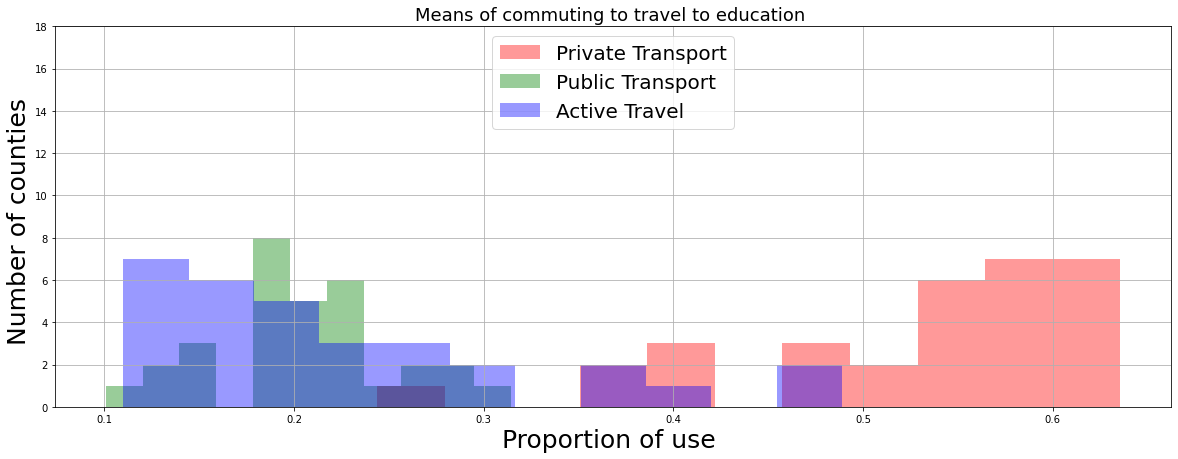

In [29]:
# set figure size
plt.figure(figsize=(20,7))

# plot histogram of each of three mode of commuting for workers 
# with distinct colours and appropriate labels and transparency
CB_county['private_edu'].hist(bins = 11,color='red',alpha=0.4, 
                         label = "Private Transport")
CB_county['public_edu'].hist(bins = 11,color='green',alpha=0.4, 
                               label = "Public Transport")
CB_county['active_edu'].hist(bins = 11,color='blue',alpha=0.4, 
                               label = "Active Travel")

# titles, labels etc.
plt.title("Means of commuting to travel to education ", fontsize = 18)
plt.legend(fontsize = 20, loc=9)
plt.xlabel('Proportion of use ', fontsize = 25)
plt.ylabel('Number of counties ', fontsize = 25)
plt.yticks(np.arange(0, 20, step = 2))
plt.show()

There is a far wider spread and more overlap on this histogram than the corresponding histogram for work commuting above.  
Private tranport is still the main mode of transport with more than half of counties having a proportion of 0.55 or above who commute to education via private transport. One county records an unusually low value of less than 0.3 for proportion who commute to education via private transport. 
Between 0.15 and 0.25 of school commmuters use public transport for most counties and all counties are contained in the range 0 to 0.3.  
Active tranpsort has the widest range of commuters, most counties have less than 0.2 school-goes commute via active transport but three counties have more than 0.35 of school-goes commute via active transport.

\newpage

### Urban/Rural Divide and link between commuting for work and education

The results above show a divide between urban and rural counties. I am going to add a categorical variable to the data to flag urban counties i.e. cities in Ireland. This will not include all cities, Limerick city and Waterford city are contained as single entities with their respective 'rural' county area so there will be a separate flag for them. 

I am also going to examine the the strength of the link between commuting for work and commuting for education for the different modes of commuting. I will examine whether modes of commuting identical for work and education or where are they different.

I will plot these proportions for commuting to work against the proportions for commmuting to education in a separate plot for each mode of commuting and use the urban/rural flag above as the colour code.

In [30]:
# list urban counties
Dublin_City = [ 'Dublin City', 'South Dublin',  'Fingal', 'Dún Laoghaire-Rathdown']
Other_City = ['Cork City','Galway City']
City_plus_county = ['Limerick City and County', 'Waterford City and County']

# create new column with different colours for urban and non-urban counties
CB_county['Region'] = 'Not City/Rural'
CB_county.loc[CB_county['Area'].isin(Dublin_City), 'Region'] = 'City - Dublin'
CB_county.loc[CB_county['Area'].isin(Other_City), 'Region'] = 'City - Outside Dublin'
CB_county.loc[CB_county['Area'].isin(City_plus_county), 'Region'] = 'City and county'

In [31]:
# import seaborn for better graphics
import seaborn as sns
sns.set_style("whitegrid")

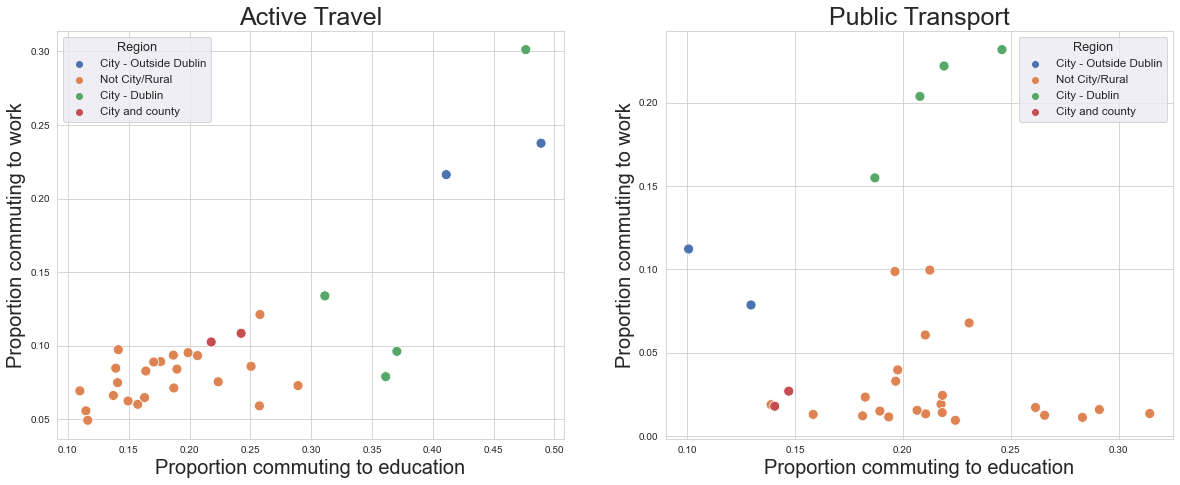

In [32]:
#set style, arrange plots etc.
sns.set_style("whitegrid")
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,7.5))
sns.set(font_scale=1.05)

# plot of active travel to education vs. active travel to work
sns.scatterplot(x="active_edu", y="active_work", data=CB_county,hue='Region', ax = ax1, s =100 )
ax1.set_title("Active Travel", fontsize = 25)
ax1.set_xlabel('Proportion commuting to education',fontsize=20)
ax1.set_ylabel('Proportion commuting to work',fontsize=20)

# plot of public transport to education vs. public transport to work
sns.scatterplot(x="public_edu", y="public_work", data=CB_county,hue='Region', ax = ax2, s = 100)
ax2.set_title("Public Transport", fontsize = 25)
ax2.set_xlabel('Proportion commuting to education',fontsize=20)
ax2.set_ylabel('Proportion commuting to work',fontsize=20)

plt.show()

There appears to be a positive linear relationship between proportions of commuters to work and commuters to education via active travel i.e. if a higher proportion in a county commuted to work by active travel, it is likely there is a higher proportion commuting to education by active travel.  

There is no sign of a similar relationship for commuting via public transport.The scatterplot shos a high concentration of Y-values below 0.05 but a much wider spread along the X-axis. In most counties, more than 0.15 of school children take public transport to education wheras only three counties have more than 0.15 of workers take public transport to work, all four being in Dublin. The lack of relationship here can likely be explained again by the provision of school bus routes, primarily in rural area which skews the relationship between commuting for educationa and commuting for work in a county. 

\newpage

### Commute length 

Having an excessively long commute has a detrimental effect on a person's quality of life, it reduces their time to spend with family, availability to socialise etc. For an average worker, working five days a week for 46 weeks of the year, a ten minute increase in commuting time each-way will accumulates to over 75 extra hours spent commuting over the course of a year. In this section I want to identify where in Ireland has the longest commutes and if there exists and a county-level a relationship between mode of commuting and length of commute. 

In [33]:
# weighted average for every legth of commute, weights as total commuting population 
print('The weighted average proportion of commuters with a short commute ( < 30 mins) is:', 
     round(np.average(CB_county['short_length'], weights=(CB_county['education'] + CB_county['Total - Work'])),3))
print('The weighted average proportion of commuters with a mid length commute (> 30 mins, < 1 hour ) is:', 
     round(np.average(CB_county['mid_length'], weights=(CB_county['education'] + CB_county['Total - Work'])),3))
print('The weighted average proportion of commuters with a long commute (> 1 hour) is:', 
     round(np.average(CB_county['long_length'], weights=(CB_county['education'] + CB_county['Total - Work'])),3))
print('\n')

# top 5 rows of data ordered by highest proportion of commuters who have a short commute
print('The counties with the highest proportion having a short commute ( < 30 mins):')
print(CB_county.sort_values(by=['short_length'], ascending=False)[['Area', 'short_length']].head())
print('\n')

# top 5 rows of data ordered by highest proportion of commuters who have a long commute
print('The counties with the highest proportion having a long commute (> 1 hour):')
print(CB_county.sort_values(by=['long_length'], ascending=False)[['Area', 'long_length']].head())

The weighted average proportion of commuters with a short commute ( < 30 mins) is: 0.592
The weighted average proportion of commuters with a mid length commute (> 30 mins, < 1 hour ) is: 0.224
The weighted average proportion of commuters with a long commute (> 1 hour) is: 0.081


The counties with the highest proportion having a short commute ( < 30 mins):
                         Area  short_length
27  Waterford City and County      0.706996
25                      Sligo      0.699545
0                   Cork City      0.693182
9                 Galway City      0.692463
6                     Donegal      0.685769


The counties with the highest proportion having a long commute (> 1 hour):
       Area  long_length
29  Wicklow     0.150550
19    Meath     0.141947
11  Kildare     0.135886
8    Fingal     0.122755
18    Laois     0.119778


Meath, Wicklow and Kildare are the three counties with the highest proportion of their population commuting over an hour, over 13% of each of those counties spend over 2 hours commuting a day.  

All three of these counties border with Dublin, the capital of Ireland and centre of economic activity and this region is known as the "commuter belt" of Dublin. [Approximately 20'000](https://www.cso.ie/en/releasesandpublications/ep/p-cp6ci/p6cii/p6www/) from each of these three counties commute to Dublin daily for work. This likely contributes to their long commute times. The next county on the list of commuters who work in a different county is Louth with 4'900 of it's inhabitants commuting to a different county. 

I am going to add a new value to the *Region* column called 'Outside Dublin' to capture these three counties and their unique commuting demographics.

In [34]:
# list of appropriate columns
Dublin_Area = ['Meath', 'Wicklow', 'Kildare']

# add value to Region column
CB_county.loc[CB_county['Area'].isin(Dublin_Area), 'Region'] = 'Outside Dublin'

The variables of "commuting length" are not divided by work and education as I have looked at previously so I will need to calculate a proportion of the total population for each mode of commuting, weighted by the numbers in each cohort e.g. this will be the proportion of all commuters who commute via active travel etc.

In [35]:
# new column - active_total
# weighted average proportion of commuters who commute via active travel
CB_county['active_total'] = (((CB_county['active_edu']*CB_county['education'])+ 
                             (CB_county['active_work']*CB_county['Total - Work']))
                             / (CB_county['education'] + CB_county['Total - Work']))

# new column - public transport
# weighted average proportion of commuters who commute via public transport
CB_county['public_total'] = (((CB_county['public_edu']*CB_county['education'])+ 
                             (CB_county['public_work']*CB_county['Total - Work']))
                             / (CB_county['education'] + CB_county['Total - Work']))

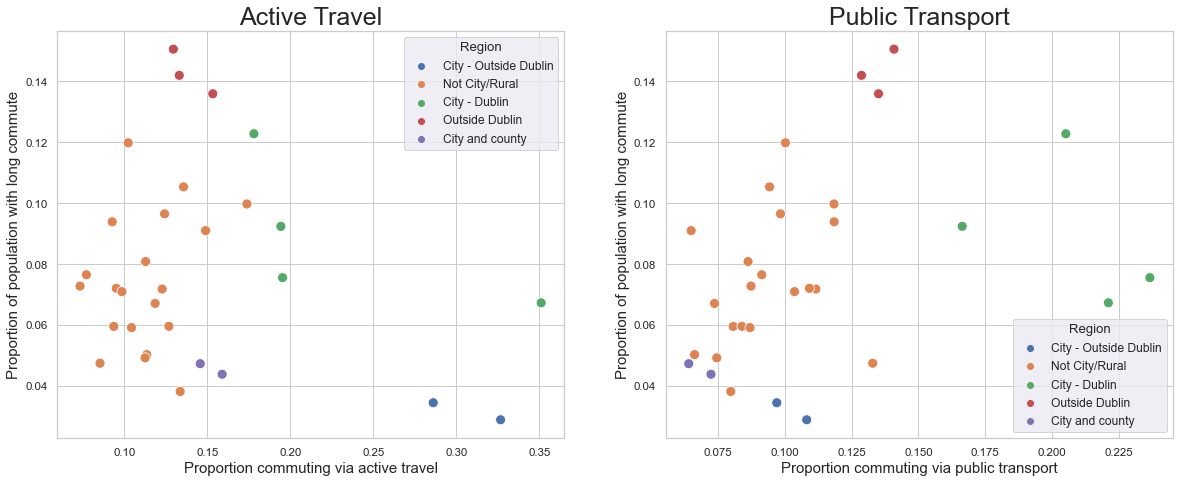

In [36]:
#set style, arrange plots  and font size
sns.set_style('whitegrid')
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,7.5))
sns.set(font_scale=1.1)

# plot of active travel proportion vs. long commute proportion, colour by region
sns.scatterplot(x="active_total", y="long_length", data=CB_county,hue='Region', ax = ax1, s =100 )
ax1.set_title("Active Travel", fontsize = 25)
ax1.set_xlabel('Proportion commuting via active travel',fontsize=15)
ax1.set_ylabel('Proportion of population with long commute',fontsize=15)

# plot of public transport proportion vs. long commute proportion, colour by region
sns.scatterplot(x="public_total", y="long_length", data=CB_county,hue='Region', ax = ax2, s = 100)
ax2.set_title("Public Transport", fontsize = 25)
ax2.set_xlabel('Proportion commuting via public transport',fontsize=15)
ax2.set_ylabel('Proportion of population with long commute',fontsize=15)

plt.show()

There does not seem to be any visible linear relationship between mode of commuting and proportion having a long commute for any mode of commuting on a county scale. However, it does support my views that the counties surrounding Dublin have longer commutes i.e. more commuters having long commutes and less commuters having short commutes than the rest of the country.      

Commuters in Cork City, Galway City, Limerick City and County and Waterford City and County less likely to have long commutes than the most of the counties while the values for the cities in Dublin vary between 0.06 and 0.13 of their population.

Dublins commuter belt seems to have a lower use of public transport than Dublin city but higher use than most of the rest of Ireland. The proportion of the population of this region who commute via active transport is slightly higher than the median.

### Occupations

In this section I am going to look at the prevalence of the different occupation categories across regions of Ireland defined over previous sections and if there is a relationship between any particular type and a mode of commuting.

In [37]:
# mean proportion who work in each profession category by region
occ = CB_county[['professional', 'service', 'trade', 'low_skilled', 'Region']]
occ = occ.groupby(['Region']).mean()

<Figure size 1440x360 with 0 Axes>

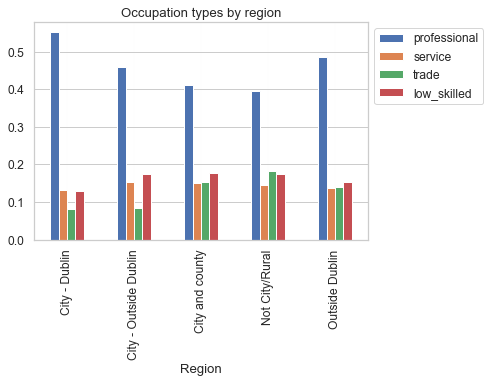

In [38]:
sns.set_style('whitegrid')
plt.figure(figsize=(20,5))
occ.plot(kind ='bar')
plt.title("Occupation types by region")
plt.grid(axis = 'x',linestyle = '--', linewidth = 0.01)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

Professional employment - consisting of Managers, directors and senior officials, Professional occupations, Associate professional and technical occupations and Administrative and secretarial occupations -  is by far the most prevalent form of occuption accross all regions.  
Over half of those working in Dublin are professionals while in counties with no city, just under 0.4 of those employed are professional.  

The remaining three occupation types are almost entirely contained between 0.1 and 0.2 of the population except for Dublin, Cork City and Galway City where less than 0.1 of the working population are employed in a skilled trade occupation.  

Now I will investigate if a relationship exists between these two forms of occupation and the modes of commuting.

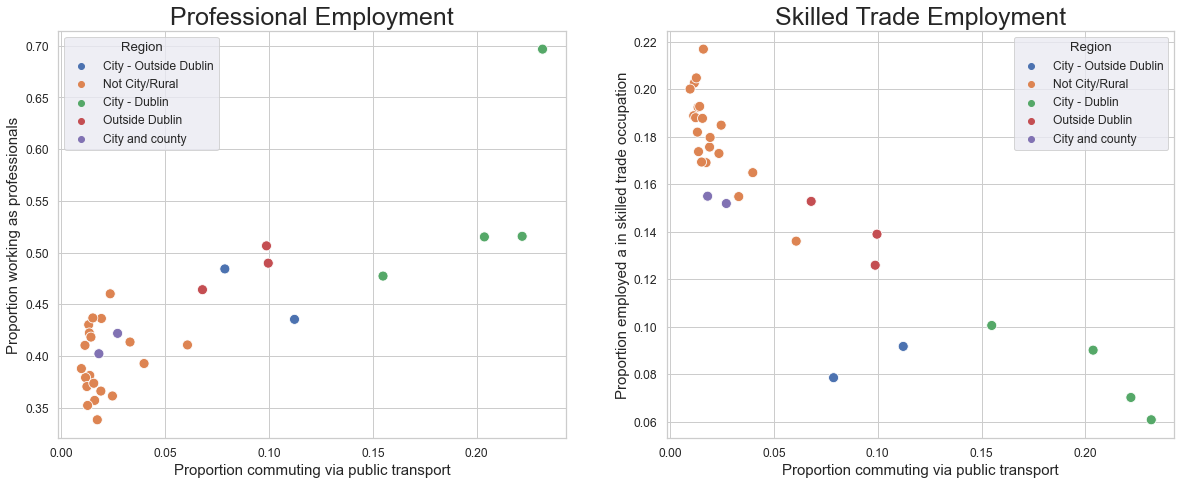

In [39]:
#set style, arrange plots  and font size
sns.set_style('whitegrid')
fig, (ax2, ax3) = plt.subplots(1,2, figsize=(20,7.5))
sns.set(font_scale=1.1)
# plot of public transport proportion vs. long commute proportion, colour by region
sns.scatterplot(x="public_work", y="professional", data=CB_county,hue='Region', ax = ax2, s = 100)
ax2.set_title("Professional Employment", fontsize = 25)
ax2.set_xlabel('Proportion commuting via public transport',fontsize=15)
ax2.set_ylabel('Proportion working as professionals',fontsize=15)

# plot of public transport proportion vs. long commute proportion, colour by region
sns.scatterplot(x="public_work", y="trade", data=CB_county,hue='Region', ax = ax3, s = 100)
ax3.set_title("Skilled Trade Employment", fontsize = 25)
ax3.set_xlabel('Proportion commuting via public transport',fontsize=15)
ax3.set_ylabel('Proportion employed a in skilled trade occupation',fontsize=15)
plt.show()

There seems to be linear relationships existing for each mode of transport and the two forms of occupation but seems to be strongest with public transport.  There is a strong negative linear relationship between the proportion who commute to work via public transport and proportion who work in skilled trade occupation. Conversely, there is a strong poistive relationship between the proportion who commute to work via public transport and proportion who work in a professional occupation.  The relationship between active travel and occupation mirrors the relationship between public travel and occupation but to a lesser degree.

It can be taken from this that in a county, as the proportion of people employed as professionals increases, the proportion who commute via public and active transport also increases while if the proportion employed in skilled trade employment increases, the proportion who commute via public transport decreases.

### General Health of population

In this final section of the exploratory data analysis I am going to look at the theme of general health of the population. The general health of the population variable table has been reduced and agregrated to three values - good health or better, fair, bad health or worse but I will be primarily concerned with good health or better and the bad health or worse values.  

In [40]:
# weighted average for every legth of commute, weights as total commuting population 
print('The weighted average of the popualtion in good health or better is:', 
     round(np.average(CB_county['good_health'], weights=(CB_county['Total_Health'])),3))
print('The weighted average of the population in bad health or worse is:', 
     round(np.average(CB_county['bad_health'], weights=(CB_county['Total_Health'])),3))
print('\n')

print('The five counties with the highest proportion in good health or better:')
print(CB_county.sort_values(by=['good_health'], ascending=False)[['Area', 'good_health']].head())
print(CB_county.sort_values(by=['good_health'], ascending=False)[['Area', 'good_health']].tail())

print('\n')
print('The five counties with the highest and lowest proportion in bad health or worse:')
print(CB_county.sort_values(by=['bad_health'], ascending=False)[['Area', 'bad_health']].head())
print(CB_county.sort_values(by=['bad_health'], ascending=False)[['Area', 'bad_health']].tail())

The weighted average of the popualtion in good health or better is: 0.87
The weighted average of the population in bad health or worse is: 0.016


The five counties with the highest proportion in good health or better:
                      Area  good_health
7   Dún Laoghaire-Rathdown     0.899417
19                   Meath     0.896305
11                 Kildare     0.895058
2              Cork County     0.895010
29                 Wicklow     0.886747
           Area  good_health
17      Leitrim     0.858101
6       Donegal     0.855608
14     Longford     0.852763
0     Cork City     0.835664
5   Dublin City     0.827842


The five counties with the highest and lowest proportion in bad health or worse:
                        Area  bad_health
0                  Cork City    0.022171
14                  Longford    0.020527
5                Dublin City    0.020207
16  Limerick City and County    0.018687
23                 Roscommon    0.018499
                      Area  bad_health

Values for good_health range between 0.8 and 0.9 for all counties i.e. for every county between 80% and 90% of their population would describe themselves as being in good health or better with the weighted average being 87%. For bad_health, values range betweeen 0.012 and 0.023 i.e. for every county between 1.2% and 2.3% would describe themselves as being in bad health or worse with an average of 1.6%.  

Dún Laoghaire-Rathdown, Meath and Cork County are the only counties in the five in terms of proportion in good health or better and five lowest counties in terms of proportion in bad health or worse.
Cork City, Longford and Dublin City the top three counties in terms of proportion in bad health or worse and the three lowest counties in terms of proportion in good health or better.  
Both sets contain a mix of cities and rural areas so it is initially evident that urban or rural areas have higher or lower standards of general health.

\newpage

## Statistical analysis

### Hypothesis Testing - Two sample t-test

In this section of the report I will be performing t-test to confirm or reject a number of my hypothesis taken from the exploratory data analysis section of my report. A two sample t-test is a commonly used in hypothesis testing to determine if two population means are equal.

In [41]:
# import scipy.stats package to run t-tests
import scipy.stats as stats

#### Test 1: Do cities have higher proportions of active travel to work and education?   

$H_{0}$ (null hypothesis): Cities and rural counties have equal proportions who commute to work/education  
$H_{1}$ (alternate hypothesis): Cities and rural counties do not have equal proportions who commute to work/education

First I need to subset the data appropriately using the region variable I previusly created. Note: I have included the counties that include cities i.e. Waterford City and County and Limerick City and County with the cities subset.    

In [42]:
# subset data appropriately
# Waterford City and County and Limerick City and County are included with cities for this test
City = CB_county[CB_county['Region'].isin(['City - Outside Dublin', 'City and county', 'City - Dublin'])] 
Not_city = CB_county[CB_county['Region'].isin(['Not City/Rural', 'Outside Dublin'])]

In [43]:
# t-test for proprortions of students who travel actively to education
stats.ttest_ind(City['active_edu'], Not_city['active_edu'], equal_var=False)

Ttest_indResult(statistic=4.921574412920201, pvalue=0.0010666483636449912)

In [44]:
# t-test for proprortions of workers who travel actively to work
stats.ttest_ind(City['active_work'], Not_city['active_work'], equal_var=False)

Ttest_indResult(statistic=2.8008914070738924, pvalue=0.02571775379830086)

The p-value is less than 0.05 in both cases i.e. there is a less than 0.05 chance we would observe those figures given the null hypothesis is true (equal proportions commute via active transport in cities and rural areas).

Therefore, we reject the null hypothesis in both cases at a 95% significance rate. 

It is shown that there are different proportions actively commute to both work and education in cities and rural counties in Ireland.

\newpage

#### Test 2: Does Dublins commuter belt experience longer commuting times? Do results change after including the surrounding areas of other cities in Ireland?  

$H_{0}: $ Dublins commuter belt and the rest of Ireland have equal proportions who have long commutes  
$H_{1}:$ Dublins commuter belt and the rest of Ireland do not have equal proportions who have long commutes

Similar to test 1 above, I will subset my data accordingly by the Region columns, storing Dublins commuter belt as one set and the remainder of Ireland as another set. To test commuting length I will test the proportion who have short commutes ( < 30 minutes) and the proportion who have long commutes ( > 1 hour) separately for the two subsets of data..

In [45]:
# subset data appropriately
# Waterford City and County and Limerick City and County are included with cities for this test
rest_of_ireland = CB_county[CB_county['Region'] != 'Outside Dublin'] 
Dublin_commute = CB_county[CB_county['Region'] == 'Outside Dublin']

In [46]:
# t-test for proportion for have a short commute, Dublins commuter belt vs. rest of Ireland
stats.ttest_ind(Dublin_commute['short_length'], rest_of_ireland['short_length'], equal_var=False)

Ttest_indResult(statistic=-6.845212595505284, pvalue=5.2987138170967505e-05)

In [47]:
# t-test for proportion for have a long commute, Dublins commuter belt vs. rest of Ireland
stats.ttest_ind(Dublin_commute['long_length'], rest_of_ireland['long_length'], equal_var=False)

Ttest_indResult(statistic=11.310805622615193, pvalue=1.4601375765078485e-06)

p-value < 0.05 for both tests i.e. there is a less than 0.05 chance we would observe those figures given the null hypothesis is true.  
Therefore, we reject the null hypothesis in both cases at a 95% significance rate.
Dublins commuter belt has a different proportion of the population who have long and short commutes than the rest of Ireland.  

\newpage

### Regression Model

For Section 2 and Section 3 of my analysis, I will now be looking at a lower level of the census data - electoral area. County level data may be masking trends in commuting by aggregating too may commuters from different regions into one group. I will use this data alongside statistical modelling and supervised learning methods in order to model and predict commuting figures e.g. proportion who commute via active travel in a given electoral area.  

First, I will reallign the electoral area dataset with county dataset by adding total columns that were created as part of my exploratory data analysis. 

In [48]:
# weighted average proportion of commuters who commute to work and education via active travel
CB_elec_area['active_total'] = (((CB_elec_area['active_edu']*CB_elec_area['education'])+ 
                             (CB_elec_area['active_work']*CB_elec_area['Total - Work']))
                             / (CB_elec_area['education'] + CB_elec_area['Total - Work']))

# weighted average proportion of commuters who commute to work and education via public transport
CB_elec_area['public_total'] = (((CB_elec_area['public_edu']*CB_elec_area['education'])+ 
                             (CB_elec_area['public_work']*CB_elec_area['Total - Work']))
                             / (CB_elec_area['education'] + CB_elec_area['Total - Work']))

The electoral area does not contain any link to it's county so that needs to be added manually. I was not able to source a conventient complete table containing the counties of each electoral area so I contructed my own using info from the [Local Electoral Area Boundary Committee Report 2013](http://cdn.thejournal.ie/media/2013/05/boundaryreport.pdf). I then added the appropriate region value using my derived regions from the exploratory data analysis. I'll then join this data to the CB_elec_area dataset on the Area value.

In [49]:
# read in data
EA_county = pd.read_csv(path+'EA_to_county_region.csv', index_col=False,encoding = "ISO-8859-1" , dtype = 'object')
# print first five entries of table 
print(EA_county.head())
# join to CB_small_area
CB_elec_area = CB_elec_area.join(EA_county,lsuffix='_1',rsuffix='_2',how='inner')

                 Area    County         Region
0   Adare - Rathkeale  LIMERICK          RURAL
1               Ardee     LOUTH          RURAL
2              Arklow   WICKLOW  COMMUTER BELT
3           Ashbourne     MEATH  COMMUTER BELT
4  Athenry - Oranmore    GALWAY          RURAL


Split the data into test and train sets. I will use the training set to fit any models I create and use the test set to test the models on completely independent data. I'm using the `train_test_split` module from the `sklean.model_selection` package to do this automatically, creating two data sets, EA_train and EA_test, the training and testing data for CB_electoral_area respectively. I have chosen a train size of 0.75 i.e. a random 0.75 of observations are in the training dataset and the remaining 0.25 of observations are in the testing dataset.

In [50]:
from sklearn.model_selection import train_test_split
EA_train , EA_test=train_test_split(CB_elec_area ,test_size=0.25)

To model my variables of interest, proportion of the population who commute via active travel and public transport I will attempt to fit linear regression model to the data. Linear regression is chosen for it's easy interpretation and explanation of values and it's ability to use multiple predictor variables of different types e.g. numeric or categorical against a single response variable. The general form for a multiple regression model is as follows:
$$ Y_i =  X_i\beta + \epsilon_i $$  
$Y_i$ is the vector of response values  
$X_i$ is the matrix of predictor values  
$\beta$ is the vector of coeeficients i.e. how $Y_i$ changes, depending on $X_i$  
$\epsilon$ is the difference between the actual value of the response and the precticted value based on $X_i$ and $\beta$, also known as the error  

Least square regression derives values for $\beta$ in order to minimize the sum of the squares of the error terms. The `smf` module of the `statsmodels.formula.api` package is imported to fit the model. 

In [51]:
# import package
import statsmodels.formula.api as smf

After a combination of using results from the exploratory data analysis and trial and error, these are the models with best fit for the two response varaiables of interest - public_total i.e. the total proportion who commute via public transport and active total i.e. the total proportion who commute via public transport.  

public_total is modelled using the following predictor variables:
- good_health - the proportion of the population in good health or better
- short_length - the proportion of the population with a commute less than 30 minutes
- region - derived regions of the counties of Ireland

active_total is modelled using the following predictor variables:
- trade - the proportion of the population in skilled trade employment
- good_health - the proportion of the population in good health or better
- region - derived regions of the counties of Ireland

In [52]:
# fit model using good health, short_length and region
mod_public = smf.ols(formula='public_total ~ good_health + short_length + Region', data=EA_train)
res_public = mod_public.fit()

print(round(res_public.rsquared_adj*100, 5), 
      "% of the variation in the response variable is explained by the predictor variables in this model")
print(res_public.params)
print("All parameters are significant at a 0.05 level of significance")

77.05441 % of the variation in the response variable is explained by the predictor variables in this model
Intercept                  0.458887
Region[T.CITY - OTHER]    -0.067521
Region[T.COMMUTER BELT]   -0.072652
Region[T.RURAL]           -0.090973
good_health               -0.144478
short_length              -0.235677
dtype: float64
All parameters are significant at a 0.05 level of significance


A basic interpretation of the parameters for this model:
- Other cities, commuter belt and rural regions have lower expected values of proportion who commute via public transport than Dublin
- As proportion of population in good health increases, the expected value of proportion who commute via public transport decreases
- As proportion of population who have short commutes increases, the expected value of proportion who commute via public transport decreases

In [53]:
mod_active = smf.ols(formula='active_total ~ trade + good_health +  Region ', data=EA_train)
res_active = mod_active.fit()
print(round(res_active.rsquared_adj*100, 5), 
      "% of the variation in the response variable is explained by the predictor variables in this model\n",)
print(res_active.params)
print("All parameters are significant at a 0.05 level of significance")

74.94636 % of the variation in the response variable is explained by the predictor variables in this model

Intercept                  1.773361
Region[T.CITY - OTHER]     0.049379
Region[T.COMMUTER BELT]   -0.008150
Region[T.RURAL]           -0.045900
trade                     -0.751598
good_health               -1.699125
dtype: float64
All parameters are significant at a 0.05 level of significance


A basic interpretation of the parameters for this model while holding all other parameters constant:
- Commuter belt and rural regions have lower expected values of proportion who commute via active travel than Dublin
- Other cities (Cork and Galway) have higher expected values of proportion who commute via active travel than Dublin
- As proportion of population who work in a skilled trade occupation increases, the expected value of proportion who commute via active travel decreases
- As proportion of population in good health increases, the expected value of proportion who commute via active travel decreases  

Now that the models are fitted, we fit the test data to the models and get our predicted values for the response variables using these values. The goodness-of-fit of the model can then be tested in two ways.

Firstly the predicted values for the response variables are graphed against the actual values of the response variables. The desired result in this instance is the points on the plot fall on or close to a 45 degree angle from the axes i.e. y = x.

In [54]:
# predict values using test data
active_pred = res_active.predict(EA_test[["trade", "good_health", "Region"]])
public_pred = res_public.predict(EA_test[["good_health", "short_length" , "Region"]])

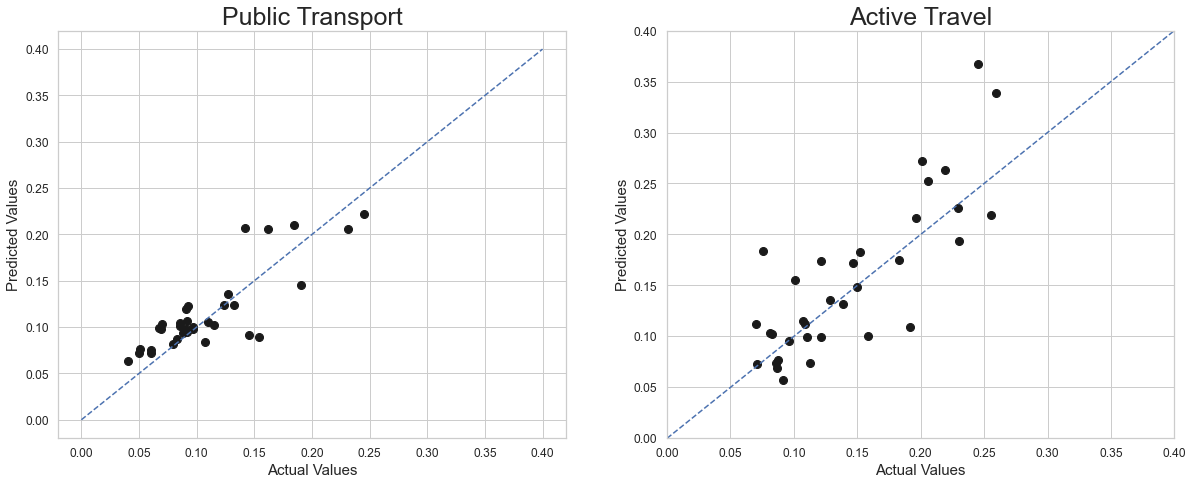

In [55]:
sns.set_style('whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7.5))
plt.xlim([0,0.4])
plt.ylim([0,0.4])

#plot 
ax1.plot(EA_test["public_total"],public_pred,'kx', markersize=8, marker='o')
ax1.plot(plt.xlim(), plt.ylim(), ls="--")
ax1.set_title("Public Transport", fontsize = 25)
ax1.set_xlabel('Actual Values',fontsize=15)
ax1.set_ylabel('Predicted Values',fontsize=15)

ax2.plot(EA_test["active_total"] , active_pred,'kx', markersize=8, marker='o')
ax2.plot(plt.xlim(), plt.ylim(), ls="--")
ax2.set_title("Active Travel", fontsize = 25)
ax2.set_xlabel('Actual Values',fontsize=15)
ax2.set_ylabel('Predicted Values',fontsize=15)
plt.show()

In [56]:
MSE_reg = np.mean(pow((EA_test["active_total"] - active_pred),2))
print("The mean squared error of the model predicting total active travel for commmuting is ", round(MSE_reg, 4) )
MSE_reg = np.mean(pow((EA_test["public_total"] - public_pred),2))
print("The mean squared error of the model predicting total public transport for commmuting is ", round(MSE_reg, 4))

The mean squared error of the model predicting total active travel for commmuting is  0.0032
The mean squared error of the model predicting total public transport for commmuting is  0.0007


Visually interpretting the plots of fitted vs actual values, the model for public transport seems a better fit for the data, the points are generally closer to the line than the model for active travel. The lower mean squared error of the estimates also supports this claim.

### Unsupervised Learning/Clustering

For my final piece of analysis, I am going to develop a cluster model to predict the regions of the data i.e. - Dublin City, Other City, Dublin Commuter Belt and Rural as cluster within the data for electoral area.  
public_total (proportion who commute via public transport) and short_length (proportion with commutes less than 30 mins) are the response variable with the best-fit model and the strongest estimator in the best-fit model respectively so I will use these variables to predict clusters in the data and compare them to the clusters of region.  

k-means clustering is chosen due to its simplicity and it's ability to adapt to clusters of different shapes and sizes. A predetermined number of clusters must be defined by the user which is approporiate as I know how many clusters I am looking for.  The algorithm works by first centring clusters at random and each data point is assigned to the cluster with the closest centre. The mean value of each variable in each of the clusters is computed and the means are used as the new centres. This process of shifting the cluster centres repeats for a predetermined number of iterations or until the cluster centres no longer change. The goal of the k-means clustering algorithm is to minimise the mean squared error, i.e. the average squared distance between each of the data points and their cluster centre.

In [57]:
# import kmeans module from sklean.cluster package
from sklearn.cluster import KMeans
# create model to estimate four clusters in the data 
cluster_model = KMeans(n_clusters=4)
#subset data to only the variables of interest
PUBLIC_CLUSTER = CB_elec_area[["public_total",  "short_length"]]
# fit the model to the data
cluster_model.fit(PUBLIC_CLUSTER)
# extract predicted values of the clusters
preds = cluster_model.predict(PUBLIC_CLUSTER)

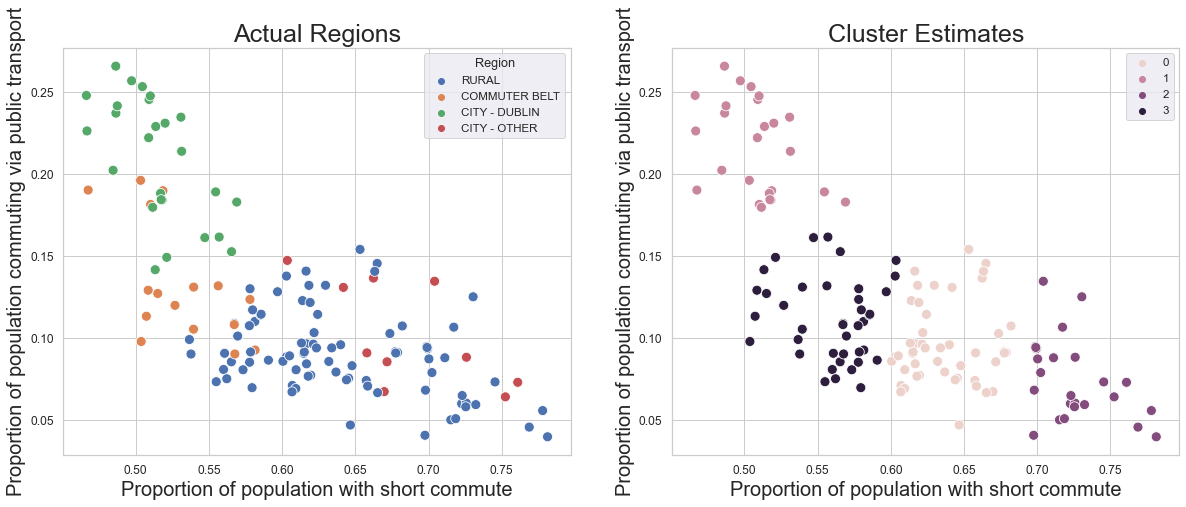

In [58]:
# initialise plot
sns.set_style("whitegrid")
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(20,7.5))
sns.set(font_scale=1.05)

# plot of public transport vs. short commute, coloured by region
sns.scatterplot(x="short_length", y="public_total", data=CB_elec_area,hue='Region', ax = ax1, s =100 )
ax1.set_title("Actual Regions", fontsize = 25)
ax1.set_xlabel('Proportion of population with short commute',fontsize=20)
ax1.set_ylabel('Proportion of population commuting via public transport',fontsize=20)

# plot of  public transport vs. short commute, coloured by cluster prediction
sns.scatterplot(x="short_length", y="public_total", data=CB_elec_area,hue=preds, ax = ax2, s = 100)
ax2.set_title("Cluster Estimates", fontsize = 25)
ax2.set_xlabel('Proportion of population with short commute',fontsize=20)
ax2.set_ylabel('Proportion of population commuting via public transport',fontsize=20)
plt.show()

There does not appear to be particularly strong clusters by region for commuting via public transport and short commute proportions. There is quite a bit of overlap between electoral areas in the commuter belt region and Dublic City Region. It is not possible to distinguish between rural areas and other cities also.  

The k-means clustering does a relatively good attempt to identfiy clusters in the data. Cluster 0 is very similar to the Dublin City region and clusters 1 and 3 combined cover most of the other cities and rural regions. Possibly showing Cork and Galway City have similar trends in public transport use and short commute proportion to rural areas as opposed to other cities i.e. Dublin. Cluster 2 captures the region of Dublins Commuter Belt but also contains multiple observations from Cluster 1 and Cluster 0.

\newpage

## Conclusion

Examining commuting, occupational and health data from the 2016 Census of Ireland has yielded a number of interesting findings. 
The vast majority of Ireland uses private transport as its mode of commuting and the cities of Ireland are the only areas where active travel and public transport achieve parity with private transport. Active transport for work and active transport for education form a linear trend which is not present for public transport. Dublin's commuter belt (Wicklow, Kildare and Meath) experience the longest commuting times in Ireland due to the high proportion of their population who commute to Dublin. 

Professional employment is the most common occupation type in Ireland and skilled trades is the least common. The more professional employment present in a county the more public transport is used while the inverse is true about skilled trade employment although this is likely more correlation than causation, due to the higher concentration of professional employement in cities where there is better access to public transport. The general health of Ireland appears in robust state with over 80% in every county considering themselves in good health or bettera and less than 3% in bad health or worse.

At an electoral area level, the proportion of the population who commute via public and active transport can both be effectively modeled by multiple linear regression. Both the proportion of the population who commute via public and active transport have a negative relationship with the proportion of the population in good health. The proportion of the population who commute via public transport also has a negative relationship with the proportion of the population who have short commutes. It is interesting and unexpected that the general health of the population would have a negative effect on the proportion who commute actively but this could likely be explained due to the higher prevalance of active commuting in urban areas. Urban areas may have a lower prevalence of good health for a number of reasons such as [air pollution](https://www.irishtimes.com/news/ireland/irish-news/bad-air-day-pollution-in-dublin-reaches-levels-of-smoky-coal-era-30-years-ago-1.4423929) etc. Using the exploratory data analysis on the county four main commuting regions were identified - Dublin Cities, Other Cities, Dublin commuter belt and rural. Attempts to fit these regions as distinct clusters in the data at an electoral-area level was inconclusive.

For further investigation into commuting trends in Ireland, I believe the best route would be to gather more qualitative data with regards to peoples perceptions of commuting and the main barriers to switching to active or public travel, if any. The impact on COVID-19 and the shift towards a Working-From-Home/hybrid working model, primarily for the professional occupation type would also need to be taken into account on any analysis on contemporary data. For future censuses, commuting data that is by gender and age would help identify demographics that lag in adapting to public/active travel. Finally there are two statistics I feel that would be of value in future censuses to further examine commuting trends. Commuting distance and availability of public transport would be two keys values that could have impact on a persons potential to alter commuting pattern and to commute by active travel and public transport respectively.